In [ ]:
import torch
import numpy as np
import json
from transformers import AutoTokenizer
import networkx as nx
import matplotlib.pyplot as plt
import hierarchical as hrc
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_theme(
    context="paper",
    style="white",  # 'whitegrid', 'dark', 'darkgrid', ...
    palette="colorblind",
    font="DejaVu Sans",  # 'serif'
    font_scale=1.75,  # 1.75, 2, ...
)

In [2]:
device = torch.device("cuda:0")
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
g = torch.load('FILE_PATH').to(device) # 'FILE_PATH' in store_matrices.py

vocab_dict = tokenizer.get_vocab()
vocab_list = [None] * (max(vocab_dict.values()) + 1)
for word, index in vocab_dict.items():
    vocab_list[index] = word

cats, G, sorted_keys = hrc.get_categories('noun')

In [3]:
import random
alpha = 0.8

num_samples = 100000
torch.random.manual_seed(100)
all_indices = torch.randperm(g.shape[0])
random_ind = all_indices[:num_samples]
random_g = g[random_ind]

proj = {}
for node in sorted_keys:
    lemmas = cats[node]
    random.seed(100)
    random.shuffle(lemmas)

    train_lemmas = lemmas[:int(alpha * len(lemmas))]
    test_lemmas = lemmas[int(alpha * len(lemmas)):]

    estimated_dir = hrc.estimate_cat_dir(train_lemmas, g, vocab_dict)
    estimated_dir = estimated_dir['lda'] / estimated_dir['lda'].norm()

    train_g = g[hrc.category_to_indices(train_lemmas, vocab_dict)]
    test_g = g[hrc.category_to_indices(test_lemmas, vocab_dict)]

    b_lda = (train_g @ estimated_dir).mean()

    proj.update({node: {'train': train_g @ estimated_dir,
                        'test': test_g @ estimated_dir,
                        'random': random_g @ estimated_dir}})

In [4]:
mean_std = {}
for node in sorted_keys:
    mean_std.update({node: {key: (proj[node][key].mean().cpu().numpy(),
                                  proj[node][key].std().cpu().numpy())
                            for key in ['train', 'test', 'random']} })

In [5]:
train_mean = [mean_std[node]['train'][0] for node in sorted_keys]
train_std = [mean_std[node]['train'][1] for node in sorted_keys]
test_mean = [mean_std[node]['test'][0] for node in sorted_keys]
test_std = [mean_std[node]['test'][1] for node in sorted_keys]
random_mean = [mean_std[node]['random'][0] for node in sorted_keys]
random_std = [mean_std[node]['random'][1] for node in sorted_keys]

In [6]:
inds = range(len(sorted_keys))
test_train  = [test_mean[i] / train_mean[i] for i in inds]
random_train = [random_mean[i] / train_mean[i] for i in inds]
test_train_std = [test_std[i] / train_mean[i] for i in inds]
random_train_std = [random_std[i] / train_mean[i] for i in inds]

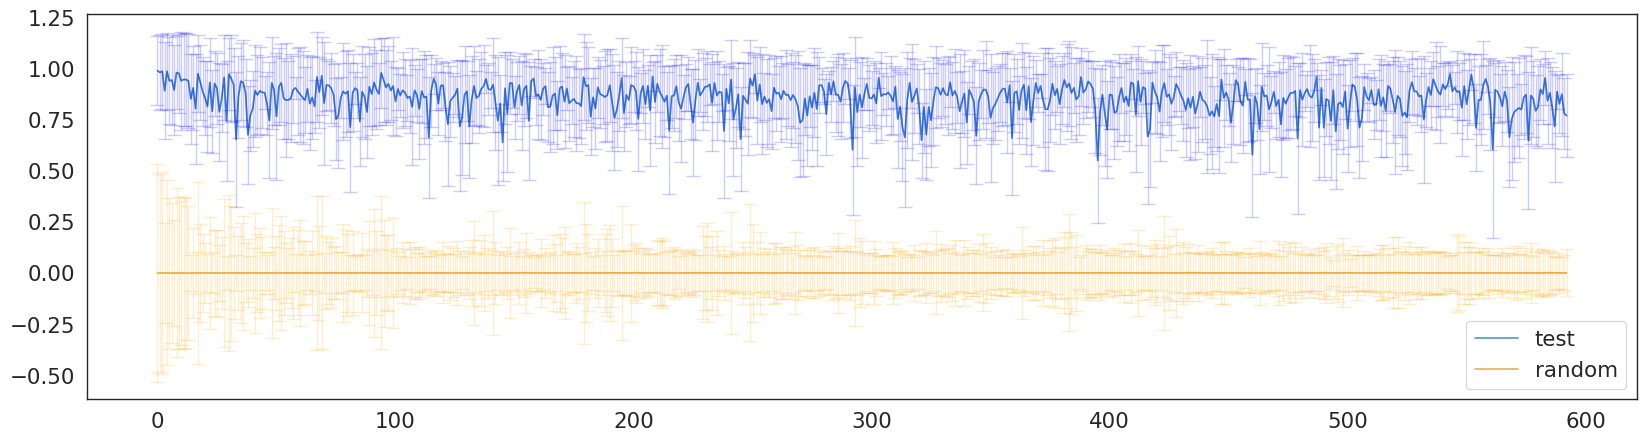

In [7]:
fig = plt.figure(figsize=(20, 5))
plt.plot(inds, test_train, alpha=0.7, label='test')
plt.plot(inds, random_train, alpha=0.7,label='random')
plt.errorbar(inds, test_train, yerr=test_train_std, color='blue', capsize=5, ecolor='blue', elinewidth=1, alpha=0.2)
plt.errorbar(inds, random_train, yerr=random_train_std, color='orange', capsize=5, ecolor='orange', elinewidth=1, alpha=0.2)
plt.legend()
plt.savefig(f"figures/noun_evaluation.pdf", bbox_inches='tight')
plt.show()